In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 12.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
import random
import math
import skimage.io
import matplotlib

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
# sys.path.append(os.path.join(ROOT_DIR, "coco/"))  # To find local version
import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [3]:
dataDir='.'
dataType='train2017'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# initialize COCO api for instance annotations
cocoDatasetAnn=COCO(annFile)

loading annotations into memory...
Done (t=15.48s)
creating index...
index created!


In [14]:
# display COCO categories and supercategories
cats = cocoDatasetAnn.loadCats(cocoDatasetAnn.getCatIds())
nms_cat=[cat['name'] for cat in cats]
print ('COCO categories: \n', ' '.join(nms_cat))

nms_scat = set([cat['supercategory'] for cat in cats])
print ('\nCOCO supercategories: \n', ' '.join(nms_scat))

COCO categories: 
 person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
 kitchen food sports vehicle person appliance furniture accessory electronic outdoor animal indoor


In [16]:
print("We have %d categories" % len(nms_cat))

We have 80 categories


In [18]:
print(imgIds)

[360452, 32773, 294918, 491526, 262161, 458772, 294933, 393241, 163866, 524314, 196639, 360480, 131108, 32809, 426026, 262191, 426031, 524338, 294962, 360500, 262197, 65594, 262207, 196675, 458827, 360528, 98390, 65632, 229472, 131172, 393317, 295015, 458856, 196715, 65643, 524401, 196723, 360570, 458876, 524420, 65668, 426118, 557191, 229511, 262286, 295055, 360595, 524436, 149, 229530, 360604, 196766, 327841, 196773, 393384, 360624, 196785, 229559, 98493, 196798, 295103, 98502, 164040, 164042, 196811, 164044, 229583, 327895, 32985, 426209, 131299, 327919, 65776, 524533, 98550, 459000, 260, 491793, 557335, 393497, 295194, 360735, 360737, 33061, 360747, 33073, 491830, 491833, 328, 393544, 459082, 262477, 393553, 459103, 229733, 164200, 262505, 393578, 557434, 131450, 426370, 262531, 65924, 196998, 524679, 197001, 524692, 360857, 491936, 295329, 295328, 65953, 393634, 524709, 131494, 419, 65962, 295340, 393647, 328111, 295343, 459184, 328119, 33208, 328120, 524730, 295358, 33215, 197057

In [17]:
# get all images containing given categories, select one at random
catIds = cocoDatasetAnn.getCatIds(catNms=['person', 'car'] );
imgIds = cocoDatasetAnn.getImgIds(catIds=catIds );
img = cocoDatasetAnn.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(len(imgIds))
img

8519


{'license': 2,
 'file_name': '000000162741.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000162741.jpg',
 'height': 640,
 'width': 479,
 'date_captured': '2013-11-17 05:06:16',
 'flickr_url': 'http://farm3.staticflickr.com/2639/3882457588_4ddf5e7ef2_z.jpg',
 'id': 162741}

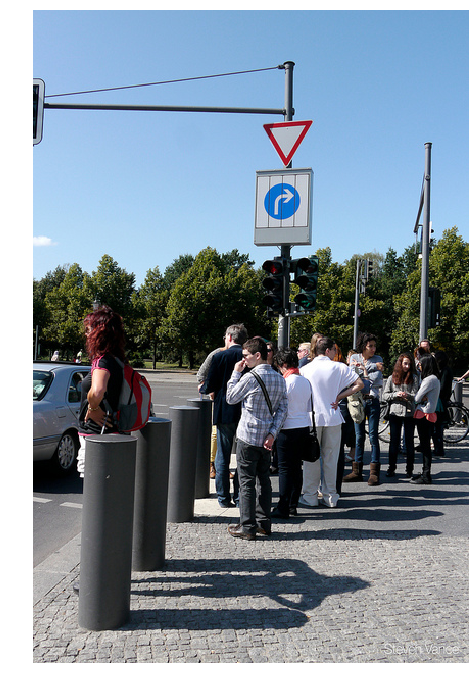

In [32]:
img = cocoDatasetAnn.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# load and display image
I = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
# I = io.imread('http://mscoco.org/images/%d'%(img['id']))
plt.figure(); plt.axis('off')
plt.imshow(I)
plt.show()

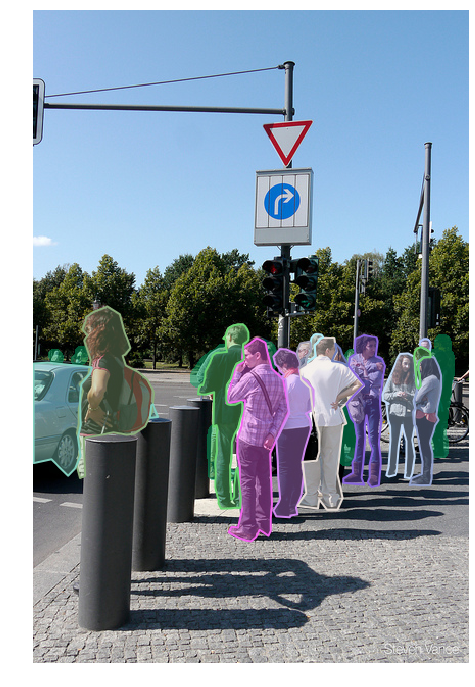

In [33]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = cocoDatasetAnn.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = cocoDatasetAnn.loadAnns(annIds)
cocoDatasetAnn.showAnns(anns)

In [34]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [35]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [36]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
len(class_names)

81

Processing 1 images
image                    shape: (511, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


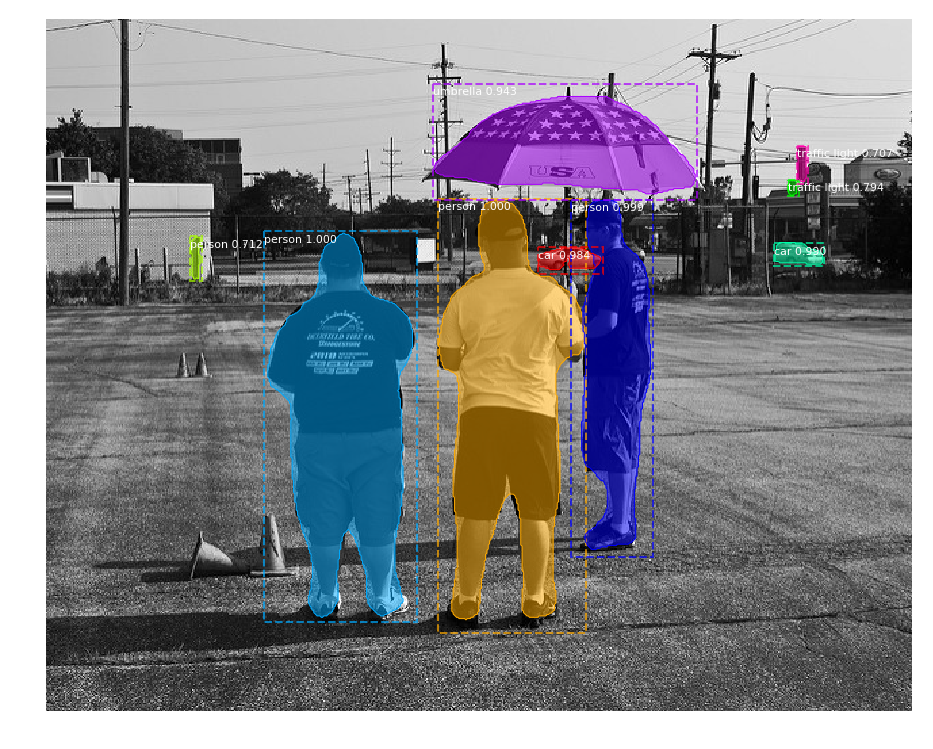

In [15]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])